# Mod 4 Project - Zillow Database and Time Series Analysis

In this project I will find the top 5 zipcodes in Utah for an imaginary real-estate firm to invest in. 
This real estate firm is looking to build a portfolio of properties with the following criteria:
* Lowering risk with diversification (varied counties, cities and price ranges)
* Time horizon for investment - 5 years
* Excellent past performance of selected zipcodes


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [3]:
#importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

from sklearn.metrics import r2_score, mean_squared_error


In [4]:
#importing Zillow housing dataset
df = pd.read_csv('zillow_data.csv')


## Choosing a state from the dataset - Utah

For this project I will expolore Utah as my chosen state. Utah is the state with the lowest median age (30.9 years) of all the US states. This is due to a large population growth in the last ten years. Between 2010 and 2018 the population in Utah grew by 14%. This means that there are many young people in Utah who will be looking for their first home to purchase. 

I will now filter this state and chosen counties from the original dataset

In [5]:
#filtering Utah zipcodes from dataset
utah  = df.loc[df.State == 'UT']

#121 unique zipcodes in Utah
len(utah.RegionName) 

121

In [7]:
utah.CountyName.unique()
# high pop counties = Salt Lake, Utah, Davis, Weber, Washington, Cashe, Tooele, Box Elder, Iron, Summit

array(['Weber', 'Davis', 'Utah', 'Salt Lake', 'Washington', 'Tooele',
       'Cache', 'Uintah', 'Box Elder', 'Summit', 'Iron', 'Wasatch',
       'Carbon', 'Duchesne', 'Morgan', 'Sevier', 'Kane', 'Juab',
       'Sanpete', 'San Juan', 'Garfield'], dtype=object)

Although there are 21 Utah counties in the dataset, over 90% of Utah's population lives in the following 10 counties:
* Salt Lake
* Utah
* Davis
* Weber
* Washington
* Cashe
* Tooele
* Box Elder
* Iron
* Summit

I will not filter these counties from the dataframe

In [8]:
#filtering for top 10 most populated counties. 90% of Utah population lives in these counties
utah = utah.loc[(utah['CountyName']== 'Salt Lake') |(utah['CountyName']== 'Utah')|(utah['CountyName']== 'Davis')|(utah['CountyName']== 'Weber')|(utah['CountyName']== 'Washington')|(utah['CountyName']== 'Cache')|(utah['CountyName']== 'Tooele')|(utah['CountyName']== 'Box Elder')|(utah['CountyName']== 'Iron')|(utah['CountyName']== 'Summit')]

In [9]:
#my dataset now has 102 zipcodes
len(utah.RegionName)

102

# Step 2: Data Preprocessing

## Transforming dataframe for analysis

In this step I will format my dataframe from wide format to long format, set the date columns as index. This will allow me to create time series.

In [10]:
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','City','State','Metro','CountyName','SizeRank']
utah_simple = utah.drop(to_drop, axis=1)

#transposing dataframe (wide format to long format)
utah_df = utah_simple.T


In this step a create a dictionary, which has the index number as the key and relevant zipcode as value. I will then use it to rename the columns with the relevant zipcode number

In [11]:
zipcode_dict = dict(pd.Series(utah.RegionName))
utah_df.rename(columns=zipcode_dict,inplace=True)

In [12]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


I will now use a function to transform the date information from the old dataframe into DateTimeIndex. I will set this as the index in my utah_df dataframe.

In [13]:
#making sure index is DatetimeIn

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

times =get_datetimes(utah)
utah_df.set_index(times, inplace=True)

In [14]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04-01,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05-01,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06-01,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07-01,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08-01,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


I will later use this dataframe for time series analysis. In the next step I will group the zipcodes into subsets for visualisations.

## Transforming dataframe for EDA

I will now create a new dataframe just for visualisations. I will drop unnecessary columns and create a **benchmark - mean** value for each zipcode.

In [15]:
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','State','Metro','SizeRank']
utah_simple_viz = utah.drop(to_drop, axis=1)

#calculate benchmark - average 
utah_simple_viz['mean'] = utah_simple_viz.mean(axis=1)
mean = utah_simple_viz.mean()


In [16]:
#dropping the benchmark columns from the dataframe. I will use this column later.
utah_simple_viz.drop('mean', axis=1,inplace=True)

In [18]:
utah_simple_viz.head()

,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,Ogden,Weber,107200.0,108200.0,109100.0,109900.0,110700.0,111400.0,112000.0,112600.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,Clearfield,Davis,120600.0,121200.0,121800.0,122500.0,123100.0,123600.0,124100.0,124600.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,Lehi,Utah,174300.0,174800.0,175000.0,175000.0,174600.0,173900.0,173300.0,172600.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,Layton,Davis,130500.0,131000.0,131500.0,132000.0,132500.0,133000.0,133400.0,133800.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,West Valley City,Salt Lake,118300.0,118200.0,118300.0,118400.0,118600.0,118800.0,119200.0,119500.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700


I will now create subset for each county.

In [19]:
#Creating a list of names of counties
counties = list(utah_simple_viz.CountyName.unique())


#Creating subsets
weber = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[0]]
davis = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[1]]
utah_c = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[2]]
salt_lake = (utah_simple_viz.loc[utah_simple_viz.CountyName == counties[3]])
washington = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[4]]
tooele = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[5]]
cache = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[6]]
box_elder = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[7]]
summit = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[8]]
iron = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[9]]


#Since counties Salt Lake and Utah contain too many zipcodes, I will split them based on cities.
salt_lake_1 = salt_lake.loc[salt_lake.City == 'Salt Lake City']
salt_lake_2 = salt_lake.loc[(salt_lake.City == 'Sandy') | (salt_lake.City == 'West Valley City')| (salt_lake.City == 'West Jordan')| (salt_lake.City == 'South Jordan')]
salt_lake_3 = salt_lake.loc[(salt_lake.City != 'Sandy') & (salt_lake.City != 'West Valley City')& (salt_lake.City != 'West Jordan')& (salt_lake.City != 'South Jordan')& (salt_lake.City != 'Salt Lake City')]

utah_1 = utah_c.loc[(utah.City == 'Orem') | (utah.City == 'Springville')| (utah.City == 'Provo')| (utah.City == 'Lehi')| (utah.City == 'Salem')| (utah.City == 'Santaquin')| (utah.City == 'Saratoga Springs')| (utah.City == 'Alpine')]
utah_2 = utah_c.loc[(utah.City != 'Orem') & (utah.City != 'Springville')& (utah.City != 'Provo')& (utah.City != 'Lehi')& (utah.City != 'Salem')& (utah.City != 'Santaquin')& (utah.City != 'Saratoga Springs')& (utah.City != 'Alpine')]

#Creating a list of subsets
counties_df = [salt_lake_1, salt_lake_2, salt_lake_3, utah_1, utah_2, weber, davis, washington, tooele, cache, box_elder, summit, iron]

In [20]:
#dropping CountyName column from dataframes
for dataframe in counties_df:
    dataframe = dataframe.drop('CountyName', axis=1, inplace=True)


In [21]:
#dropping City column from dataframes
for dataframe in counties_df:
    dataframe = dataframe.drop('City', axis=1, inplace=True)

In [22]:
#transposing subsets + renaming columns with relevant zipcodes using zipcode_dict created earlier
utah_1 = (utah_1.T).rename(columns=zipcode_dict)
utah_2 = (utah_2.T).rename(columns=zipcode_dict)
salt_lake_1 = (salt_lake_1.T).rename(columns=zipcode_dict)
salt_lake_2 = (salt_lake_2.T).rename(columns=zipcode_dict)
salt_lake_3 = (salt_lake_3.T).rename(columns=zipcode_dict)


weber = (weber.T).rename(columns=zipcode_dict)
davis = (davis.T).rename(columns=zipcode_dict)
#utah_c = (utah_c.T).rename(columns=zipcode_dict)
#salt_lake = (salt_lake.T).rename(columns=zipcode_dict)
washington = (washington.T).rename(columns=zipcode_dict)
tooele = (tooele.T).rename(columns=zipcode_dict)
cache = (cache.T).rename(columns=zipcode_dict)
box_elder = (box_elder.T).rename(columns=zipcode_dict)
summit = (summit.T).rename(columns=zipcode_dict)
iron = (iron.T).rename(columns=zipcode_dict)

In [24]:
#Checking is subsets look finished
box_elder.head()

,84302,84337,84312,84340
1996-04,112200.0,113700.0,107100.0,145800.0
1996-05,112600.0,114400.0,107800.0,146700.0
1996-06,112900.0,115000.0,108500.0,147600.0
1996-07,113300.0,115600.0,109200.0,148500.0
1996-08,113700.0,116200.0,109800.0,149300.0


In [26]:
salt_lake_1.head()

,84106,84103,84116,84102,84105,84108,84104,84111,84101
1996-04,161400.0,237200.0,109600.0,181600.0,180600.0,270000.0,93600.0,116700.0,85100.0
1996-05,161100.0,238400.0,110100.0,181200.0,180500.0,270500.0,93700.0,116900.0,85400.0
1996-06,160700.0,239500.0,110700.0,180800.0,180500.0,271000.0,93800.0,117200.0,85800.0
1996-07,160000.0,240700.0,111300.0,180300.0,180500.0,271600.0,93900.0,117400.0,86100.0
1996-08,159300.0,241800.0,111900.0,179800.0,180700.0,272100.0,94100.0,117700.0,86500.0


In [27]:
#creating lists for easier visualisations
to_plot = [salt_lake_1, salt_lake_2, salt_lake_3, utah_1, utah_2, weber, davis, washington, tooele, cache, box_elder, summit, iron]
to_plot_names = ['Salt Lake 1', 'Salt Lake 2', 'Salt Lake 3', 'Utah County 1','Utah County 2','weber', 'davis', 'washington', 'tooele', 'cache', 'box_elder', 'summit', 'iron']

# Step 3: EDA and Visualization

First, I will create a function which will create the desired visualistion for each subset.

In [28]:
#defining matplotlib style
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


def visualise_counties(df,name):
    ax = df.plot(figsize=(15,8))
    plt.plot(mean, color='black', linestyle='dashed') # the mean benchmark will be the black dashed line
    plt.title(str(name).title())
    plt.xticks(['1996-04','2000-01','2004-01','2008-01','2012-01','2016-01']) 
    plt.axvline('2000-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2004-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2008-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2012-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2016-01', color='grey', linestyle='--', lw=0.5)
    
    #this loop will add annotations to the end of each plot. This will help me interpret the line plots.
    for line, name in zip(ax.lines, df.columns):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")

In [29]:
# Creating a list for storing interesting zipcodes. I will append zipcodes to this list as I look through the visualisations.
zipcodes_to_explore = []

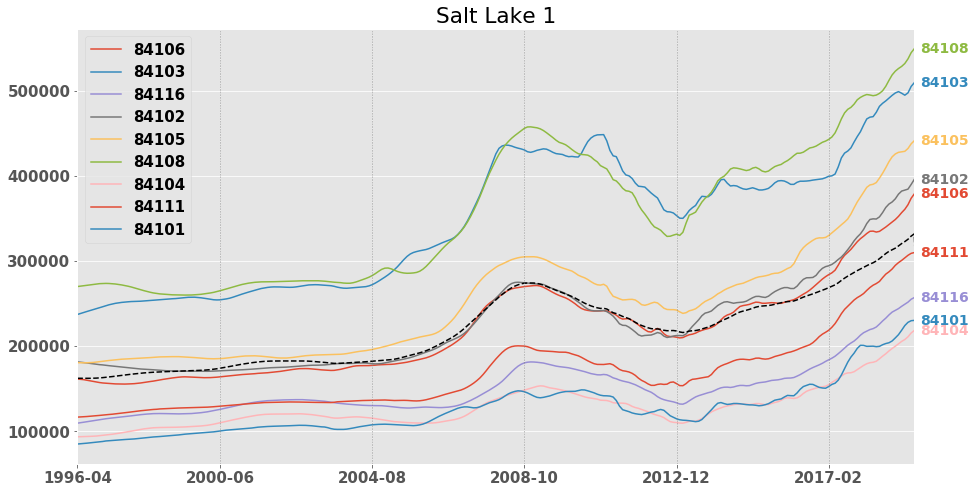

In [30]:
visualise_counties(to_plot[0],to_plot_names[0])

### Salt Lake 1
following zipcodes seem to be outperforming the rest:
* 84104
* 84102
* 84103
* 84106
* 84105



In [31]:
zipcodes_to_explore.append(84104)
zipcodes_to_explore.append(84102)
zipcodes_to_explore.append(84103)
zipcodes_to_explore.append(84106)
zipcodes_to_explore.append(84105)

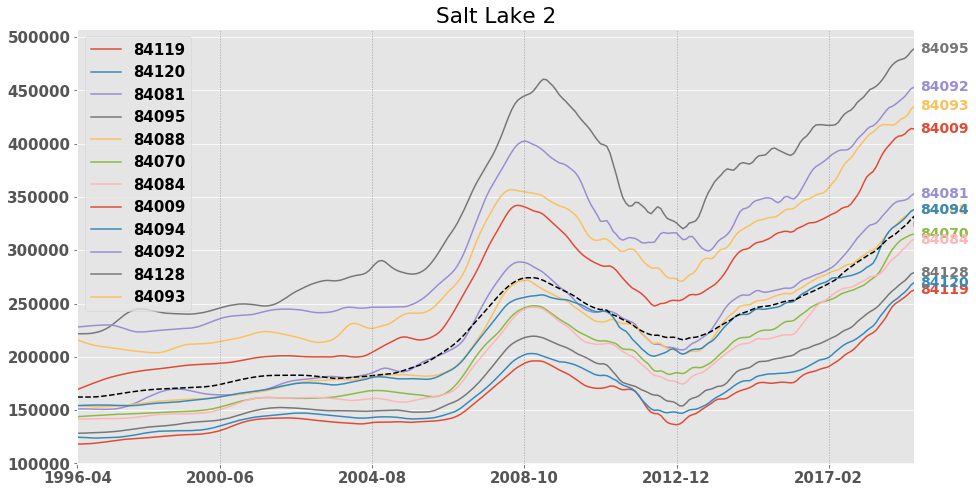

In [32]:
visualise_counties(to_plot[1],to_plot_names[1])

### Salt Lake 2
following zipcodes seem to be outperforming the rest:
* 84095
* 84093
* 84092
* 84009


In [33]:
zipcodes_to_explore.append(84095)
zipcodes_to_explore.append(84093)
zipcodes_to_explore.append(84092)
zipcodes_to_explore.append(84009)

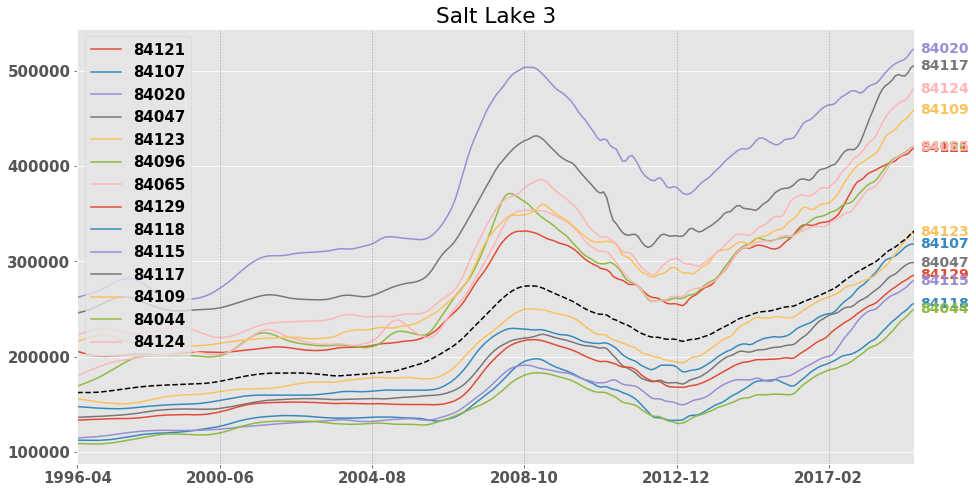

In [34]:
visualise_counties(to_plot[2],to_plot_names[2])

### Salt Lake 3 
following zipcodes seem to be outperforming the rest:
* 84117
* 84020
* 84124
* 84109
* 84065
* 84121

In [35]:
zipcodes_to_explore.append(84117)
zipcodes_to_explore.append(84020)
zipcodes_to_explore.append(84124)
zipcodes_to_explore.append(84109)
zipcodes_to_explore.append(84065)
zipcodes_to_explore.append(84121)

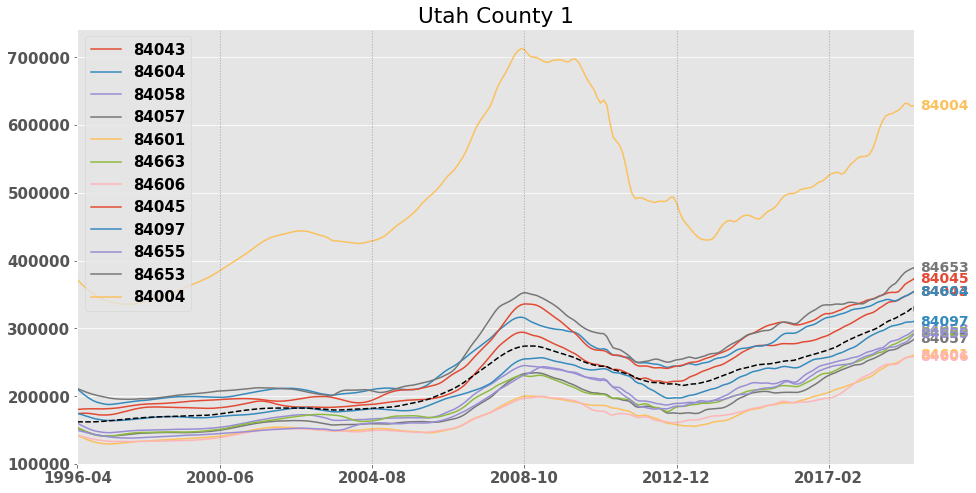

In [36]:
visualise_counties(to_plot[3],to_plot_names[3])

### Utah County 1 
following zipcodes seem to be outperforming the rest:


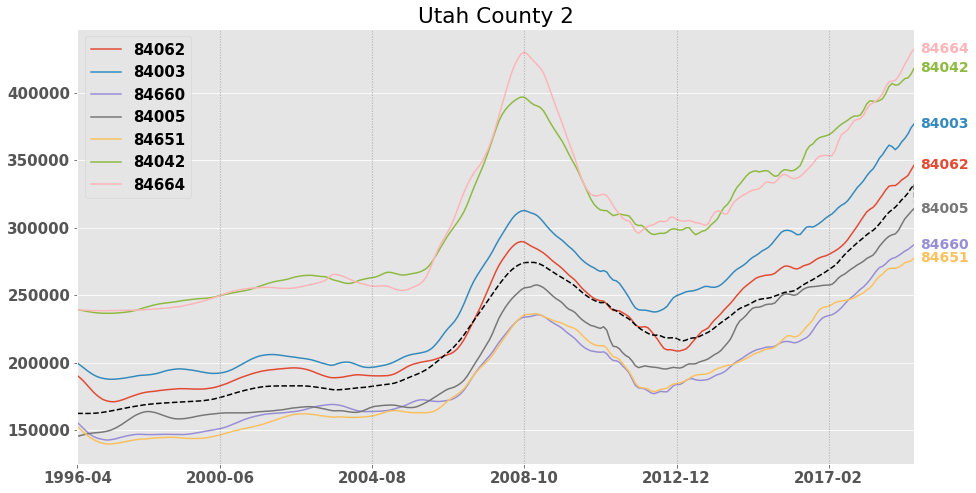

In [37]:
visualise_counties(to_plot[4],to_plot_names[4])

### Utah County 2
following zipcodes seem to be outperforming the rest:


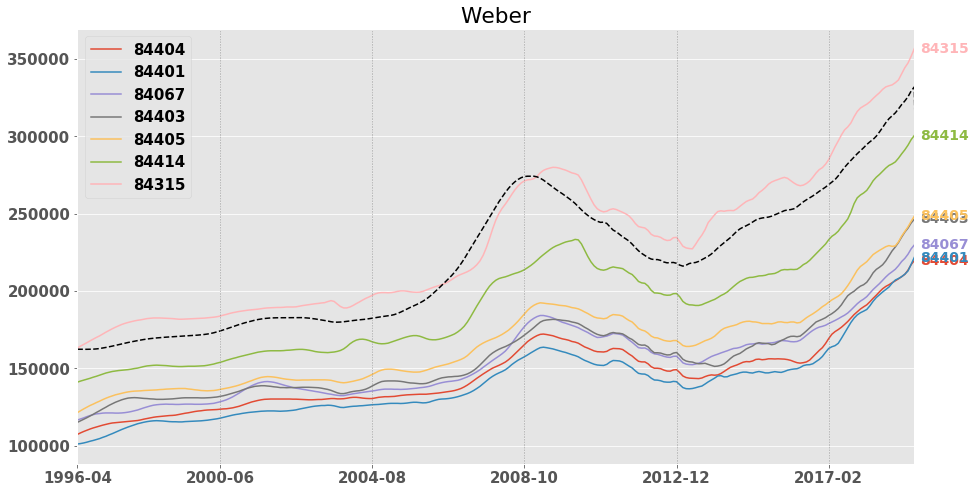

In [38]:
visualise_counties(to_plot[5],to_plot_names[5])

### Weber
following zipcodes seem to be outperforming the rest:
* 84315

In [39]:
zipcodes_to_explore.append(84315)

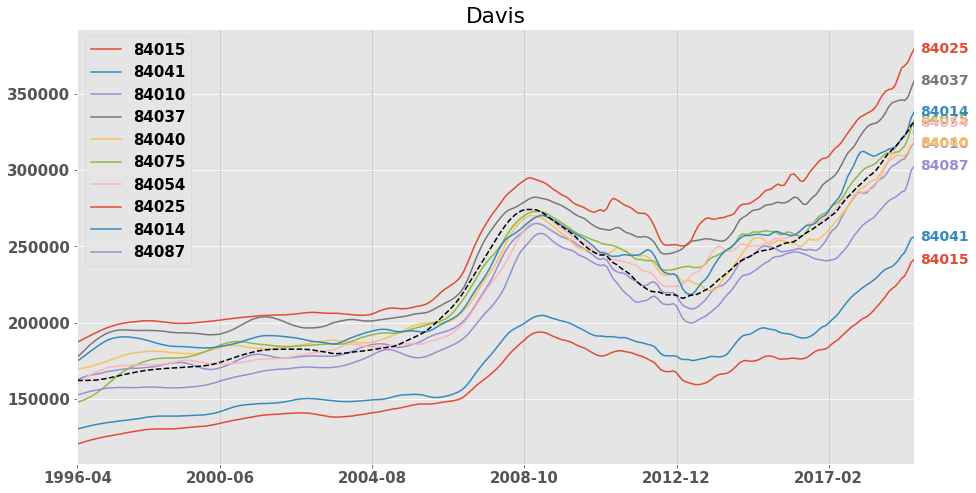

In [40]:
visualise_counties(to_plot[6],to_plot_names[6])

### Davis
following zipcodes seem to be outperforming the rest:
* 84037
* 84025

In [41]:
zipcodes_to_explore.append(84037)
zipcodes_to_explore.append(84025)

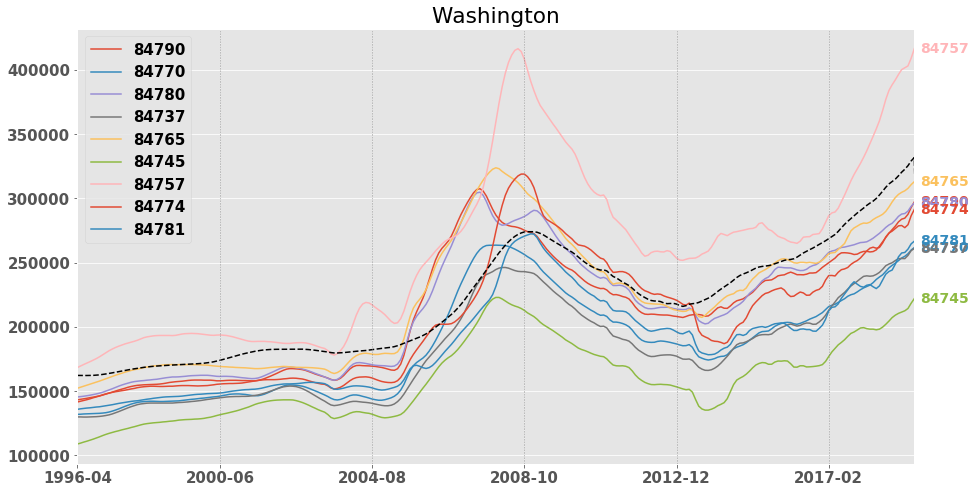

In [42]:
visualise_counties(to_plot[7],to_plot_names[7])

### Washington
following zipcodes seem to be outperforming the rest:
* 84757


In [43]:
zipcodes_to_explore.append(84757)

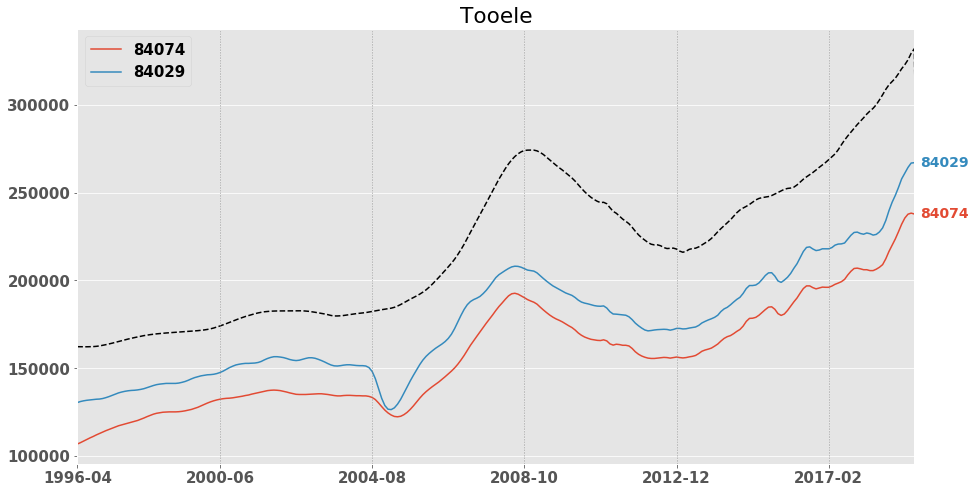

In [44]:
visualise_counties(to_plot[8],to_plot_names[8])

### Tooele
following zipcodes seem to be outperforming the rest:


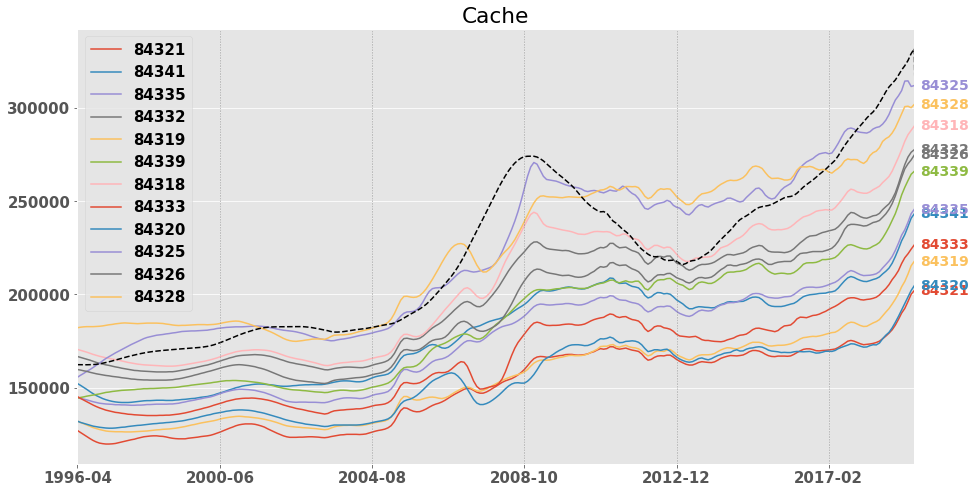

In [45]:
visualise_counties(to_plot[9],to_plot_names[9])

### Cache
following zipcodes seem to be outperforming the rest:
* 84325
* 84328

In [46]:
zipcodes_to_explore.append(84325)
zipcodes_to_explore.append(84328)

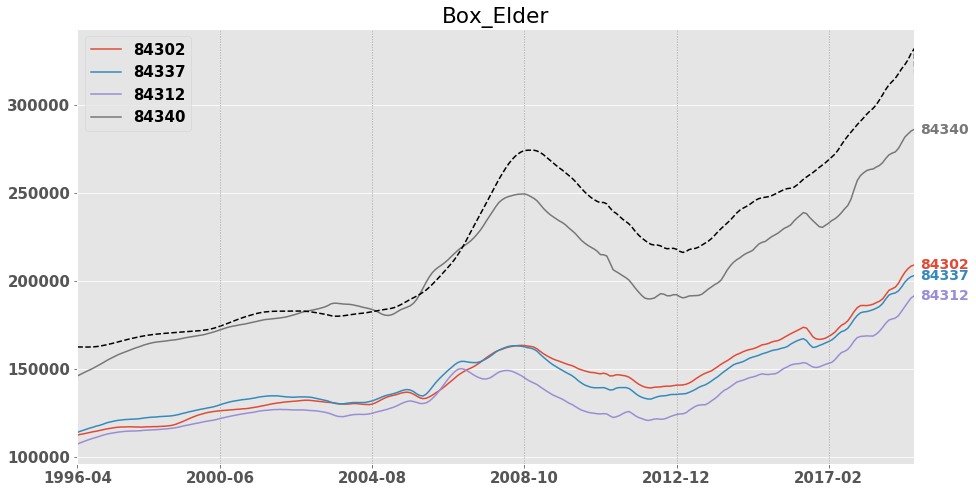

In [47]:
visualise_counties(to_plot[10],to_plot_names[10])

### Box Elder
following zipcodes seem to be outperforming the rest:


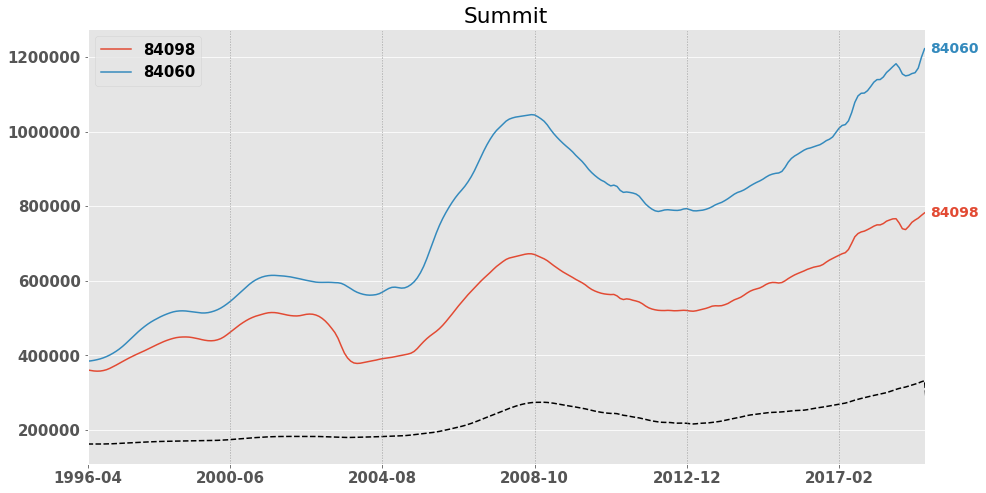

In [48]:
visualise_counties(to_plot[11],to_plot_names[11])

### Summit
following zipcodes seem to be outperforming the rest:
* 84098
* 84060

In [49]:
zipcodes_to_explore.append(84098)
zipcodes_to_explore.append(84060)

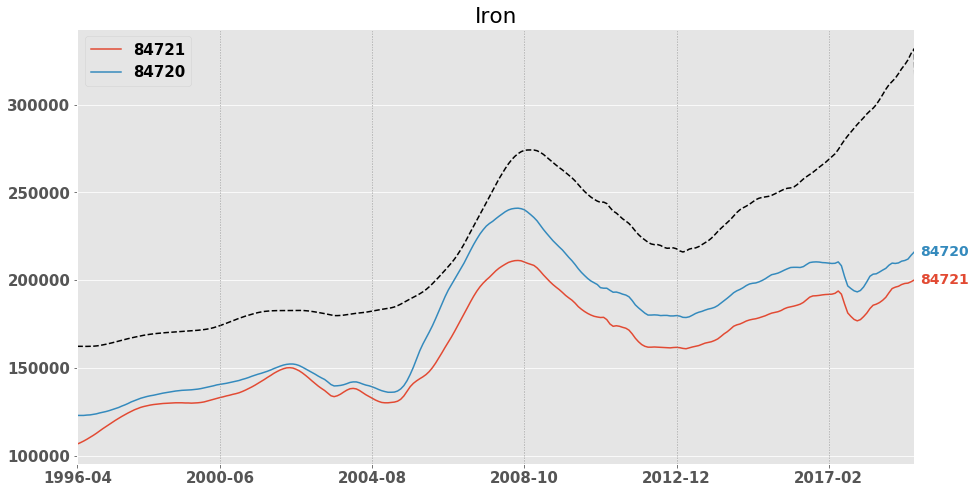

In [50]:
visualise_counties(to_plot[12],to_plot_names[12])

## Comparing selected zipcodes

In [52]:
#I have selected 23 zipcodes based on interpreting the visualisations
len(zipcodes_to_explore)

23

I will not plot these zipcodes together. I will create 2 separate visualisations, as 23 lines is too many for one plot.

In [53]:
#creating a new dataframe with selected series
viz_0 = pd.DataFrame(utah_df[int(zipcodes_to_explore[0])])
viz_1 = pd.DataFrame(utah_df[int(zipcodes_to_explore[1])])
viz_2 = pd.DataFrame(utah_df[int(zipcodes_to_explore[2])])
viz_3 = pd.DataFrame(utah_df[int(zipcodes_to_explore[3])])
viz_4 = pd.DataFrame(utah_df[int(zipcodes_to_explore[4])])
viz_5 = pd.DataFrame(utah_df[int(zipcodes_to_explore[5])])
viz_6 = pd.DataFrame(utah_df[int(zipcodes_to_explore[6])])
viz_7 = pd.DataFrame(utah_df[int(zipcodes_to_explore[7])])
viz_8 = pd.DataFrame(utah_df[int(zipcodes_to_explore[8])])
viz_9 = pd.DataFrame(utah_df[int(zipcodes_to_explore[9])])
viz_10 = pd.DataFrame(utah_df[int(zipcodes_to_explore[10])])
viz_11 = pd.DataFrame(utah_df[int(zipcodes_to_explore[11])])


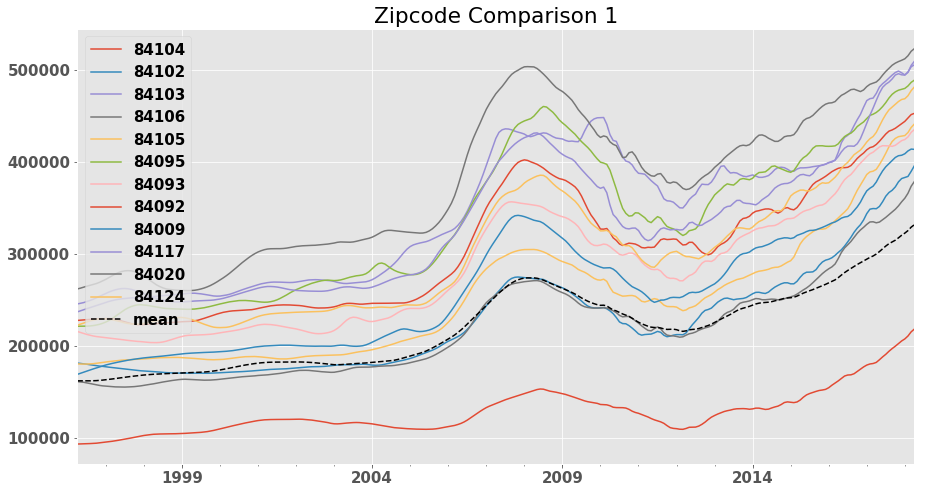

In [54]:
#calculate benchmark - average 
utah_df['mean'] = utah_df.mean(axis=1)
mean_for_final_viz = utah_df['mean']

mean_for_final_viz = pd.DataFrame(mean_for_final_viz)

#joining all data together
to_concat = [viz_0,viz_1,viz_2,viz_3,viz_4,viz_5,viz_6,viz_7,viz_8,viz_9,viz_10,viz_11,mean_for_final_viz]

final_viz_1 = pd.concat(to_concat, axis=1)

final_viz_1.plot(figsize=(15,8))
plt.title('Zipcode Comparison 1');
plt.gca().get_lines()[12].set_color('black')
plt.gca().get_lines()[12].set_linestyle('dashed')
plt.legend();

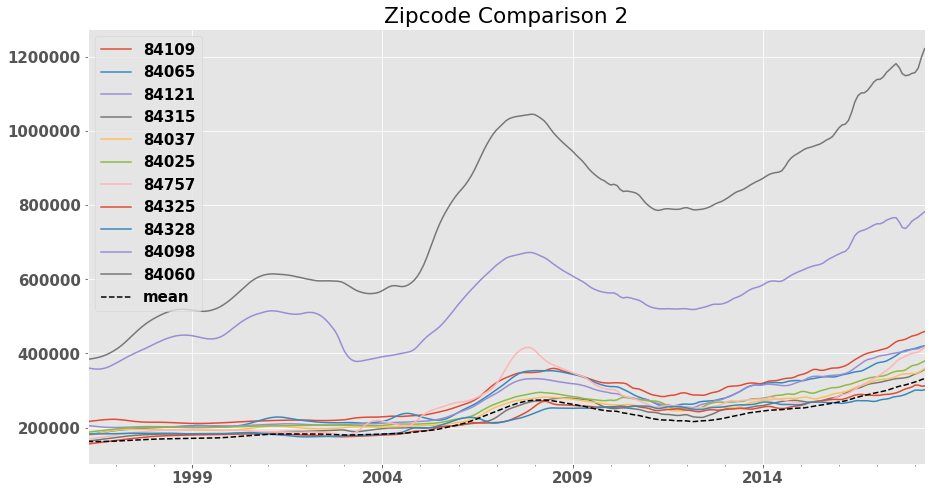

In [55]:
#creating second dataframe with selected series
viz_12 = pd.DataFrame(utah_df[int(zipcodes_to_explore[12])])
viz_13 = pd.DataFrame(utah_df[int(zipcodes_to_explore[13])])
viz_14 = pd.DataFrame(utah_df[int(zipcodes_to_explore[14])])
viz_15 = pd.DataFrame(utah_df[int(zipcodes_to_explore[15])])
viz_16 = pd.DataFrame(utah_df[int(zipcodes_to_explore[16])])
viz_17 = pd.DataFrame(utah_df[int(zipcodes_to_explore[17])])
viz_18 = pd.DataFrame(utah_df[int(zipcodes_to_explore[18])])
viz_19 = pd.DataFrame(utah_df[int(zipcodes_to_explore[19])])
viz_20 = pd.DataFrame(utah_df[int(zipcodes_to_explore[20])])
viz_21 = pd.DataFrame(utah_df[int(zipcodes_to_explore[21])])
viz_22 = pd.DataFrame(utah_df[int(zipcodes_to_explore[22])])


to_concat_2 = [viz_12,viz_13,viz_14,viz_15,viz_16,viz_17,viz_18,viz_19,viz_20,viz_21,viz_22,mean_for_final_viz]

final_viz_2 = pd.concat(to_concat_2, axis=1)

#plt.plot(mean, color='grey', linestyle='dashed')
final_viz_2.plot(figsize=(15,8))
plt.title('Zipcode Comparison 2');
plt.gca().get_lines()[11].set_color('black')
plt.gca().get_lines()[11].set_linestyle('dashed')
plt.legend();

**As we can see, almost all selected zipcodes are perfoming better than Utah's average.**
I will now have a look at the average monthly percentage change to get more insight into the top performing zipcodes.

## Comparing percentage change

In [56]:
#Joining data together
to_concat_3 = [final_viz_1, final_viz_2]
df_pct = pd.concat(to_concat_3, axis=1)

#Dropping the 'mean' 
df_pct.drop('mean', axis=1, inplace=True)

**These are the 20 zipcodes with the highest everage monthly percentage increase in value.**

In [61]:
pct_change = df_pct.pct_change().mean()
pct_change_top_20 = pct_change.sort_values(ascending=False).head(20)
pct_change_top_20

84060    0.004433
84757    0.003511
84009    0.003419
84105    0.003415
84106    0.003262
84065    0.003252
84104    0.003248
84095    0.003037
84315    0.002987
84102    0.002985
84098    0.002984
84124    0.002955
84103    0.002930
84109    0.002881
84117    0.002766
84121    0.002733
84025    0.002694
84093    0.002686
84037    0.002681
84325    0.002660
dtype: float64

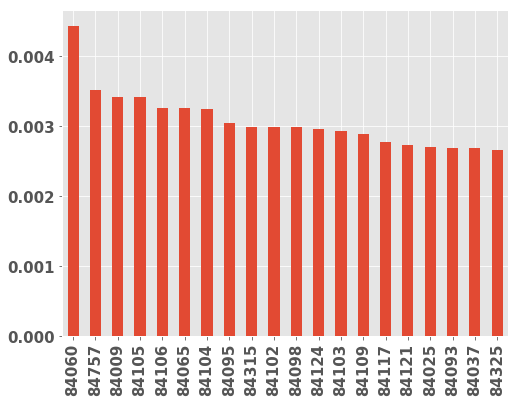

In [67]:
pct_change_top_20.plot.bar(figsize=(8,6))

## Selected  9 zipcodes for modelling:
* 84060
* 84101
* 84111
* 84757
* 84096
* 84115
* 84106
* 84081
* 84044

# Step 4: ARIMA Modeling

## Preparing for SARIMA modelling

I will now create functions that will help me with exploring and modelling the data

In [68]:
#defining a function to carry out Dickey-Fuller Test
def DF_test(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)
    
    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)

    
#defining a function for differencing (removing trend) 
def difference(ts):
    ts = ts.diff(periods=1)
    ts = ts.dropna()
    return ts


#defining a function to plot PACF (partial autocorrelation function)
def pacf_ywmle(ts,lag):
    rcParams['figure.figsize'] = 14, 5
    plot_pacf(ts, lags = lag, method = 'ywmle');
    
    
#defining a function to plot PACF (partial autocorrelation function) without the 'ywmle' parameter
def pacf(ts,lag):
    rcParams['figure.figsize'] = 14, 5
    plot_pacf(ts, lags = lag);
    
    
#defining function to substract the rolling mean (removing trend)
def minus_rollmean(ts,window):
    rolmean = ts.rolling(window = window).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    return data_minus_rolmean


#diagnostics for SARIMA output
def diagnostics(output):
    output.plot_diagnostics(figsize=(11, 11))
    plt.show()

#creating predictions based on the model's output and coefficients
#this fucntion will also print out the RMSE and mean value for assesing error level
def get_predictions(ts,output,time_from):
    pred = output.get_prediction(start=pd.to_datetime(time_from), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = ts.plot(label='Observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show()
    
    values_forecasted = pred.predicted_mean
    values_truth = ts
    
    rmse = np.sqrt(mean_squared_error(values_truth[time_from:], values_forecasted))
    print('RMSE: '+str(rmse))
    print('mean: '+str(ts[time_from:].mean()))

    
#same as above with dynamic predictions   
def get_dynamic_predictions(ts,output,time_from):
    pred = output.get_prediction(start=pd.to_datetime(time_from), dynamic=True)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = ts.plot(label='Observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show()
    
    values_forecasted = pred.predicted_mean
    values_truth = ts
    
    rmse = np.sqrt(mean_squared_error(values_truth[time_from:], values_forecasted))
    print('RMSE: '+str(rmse))
    print('mean: '+str(ts[time_from:].mean()))


## Modelling zipcode 84060 (Model #1)

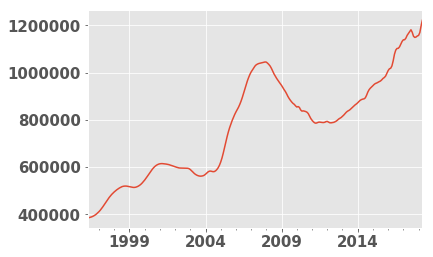

In [70]:
#plotting selected zipcode
utah_df[int(84060)].plot()

In [71]:
#Differencing to remove trend
diff_84060 = difference(utah_df[int(84060)])
difff_84060 = minus_rollmean(diff_84060,10)

In [73]:
#Testing for stationarity
DF_test(difff_84060)

(-3.3712223708681277, 0.011979903693148069, 14, 240, {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}, 4332.2548395921995)
Results of Dickey-Fuller Test:
Test Statistic                  -3.371222
p-value                          0.011980
#Lags Used                      14.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


With p-value of 0.01 we can say that this series is now stationary.
Now I will look for seasonality.

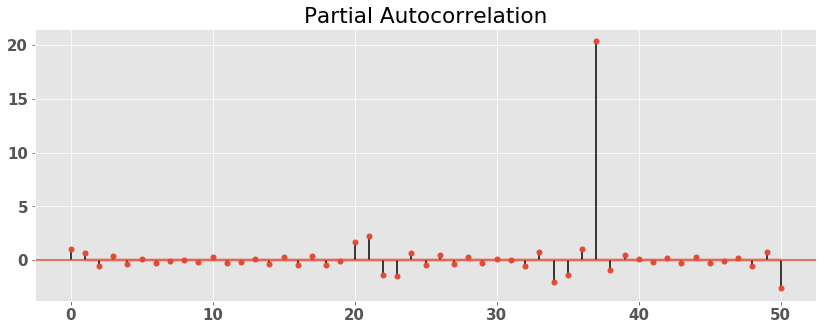

In [76]:
pacf(difff_84060['2010':],50)
#the seasonality seems to be 37!
#using the 'ywmle' parameted showed 3 as the seasonality, but this number did not work for the model.

In [77]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs =  [(x[0], x[1], x[2], 3) for x in pdq]

pdqs

[(0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3)]

In [80]:
#Creating another function which will create parameter combinations that we will then pass into the SARIMA model
def s_params(season):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0,2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    #return pdq

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
    pdqs =  [(x[0], x[1], x[2], season) for x in pdq]
    return pdq,pdqs

In [81]:
pdq =s_params(37)[0]
pdqs =s_params(37)[1]

This code will use combinations of parameters and calculate AIC for each combination.

In [82]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(utah_df[int(84060)],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}season : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [83]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 37)
aic           3587.01
Name: 63, dtype: object

In [84]:
# plug the optimal parameter values into a new SARIMAX model
# 'output' variable is now our model!
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(utah_df[int(84060)],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 37),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8929      0.037     24.421      0.000       0.821       0.965
ma.L1          0.8138      0.028     28.858      0.000       0.759       0.869
ar.S.L37       0.1559      0.082      1.901      0.057      -0.005       0.317
ma.S.L37      -0.2406      0.096     -2.502      0.012      -0.429      -0.052
sigma2      1.054e+07   6.59e+05     15.998      0.000    9.25e+06    1.18e+07


All parameters have p-values below 0.05, so this models seems good.

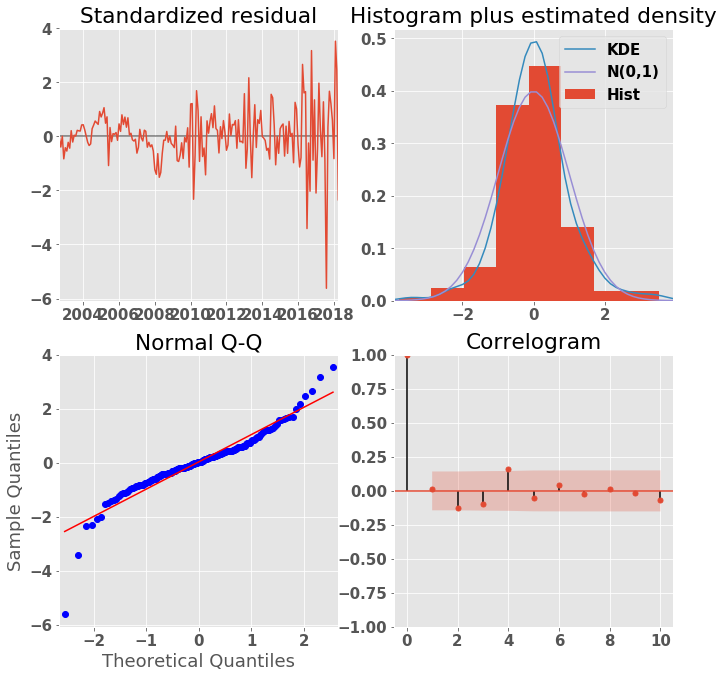

In [85]:
# Using diagnostics functions with results calculated above   
diagnostics(output)

I will not create predictions using the model from the year 2012 and plot it alongside the real values.

In [88]:
# Get predictions starting and calculate confidence intervals.
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

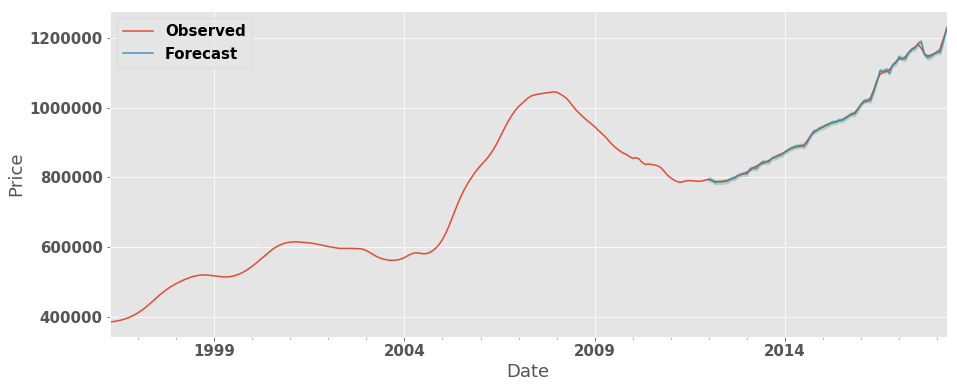

RMSE: 4483.419812219312
mean: 967840.7894736842


In [89]:
get_predictions(utah_df[int(84060)],output,'2012-01-01')

Getting dynamic predictions with confidence intervals.

In [92]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

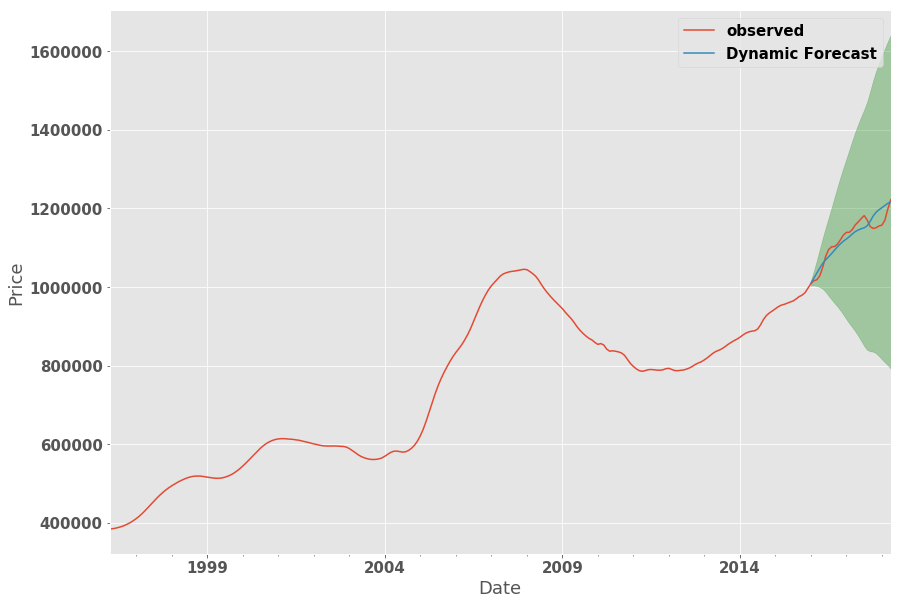

In [93]:
ax = utah_df[int(84060)].plot(label='observed', figsize=(14, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()


Calculating RMSE for dynamic prediction.

In [94]:
# Extract the predicted and true values of our time series
values_forecasted = pred_dynamic.predicted_mean
values_truth = utah_df[int(84060)]['2016':]

rmse = np.sqrt(mean_squared_error(values_truth, values_forecasted))
print('RMSE: '+str(rmse))
print('mean: '+str(values_truth.mean()))

RMSE: 21627.799971657158
mean: 1124957.142857143


Predicting future values

In [95]:
# Get forecast for a number of steps ahead in future
prediction = output.get_forecast(steps=75)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

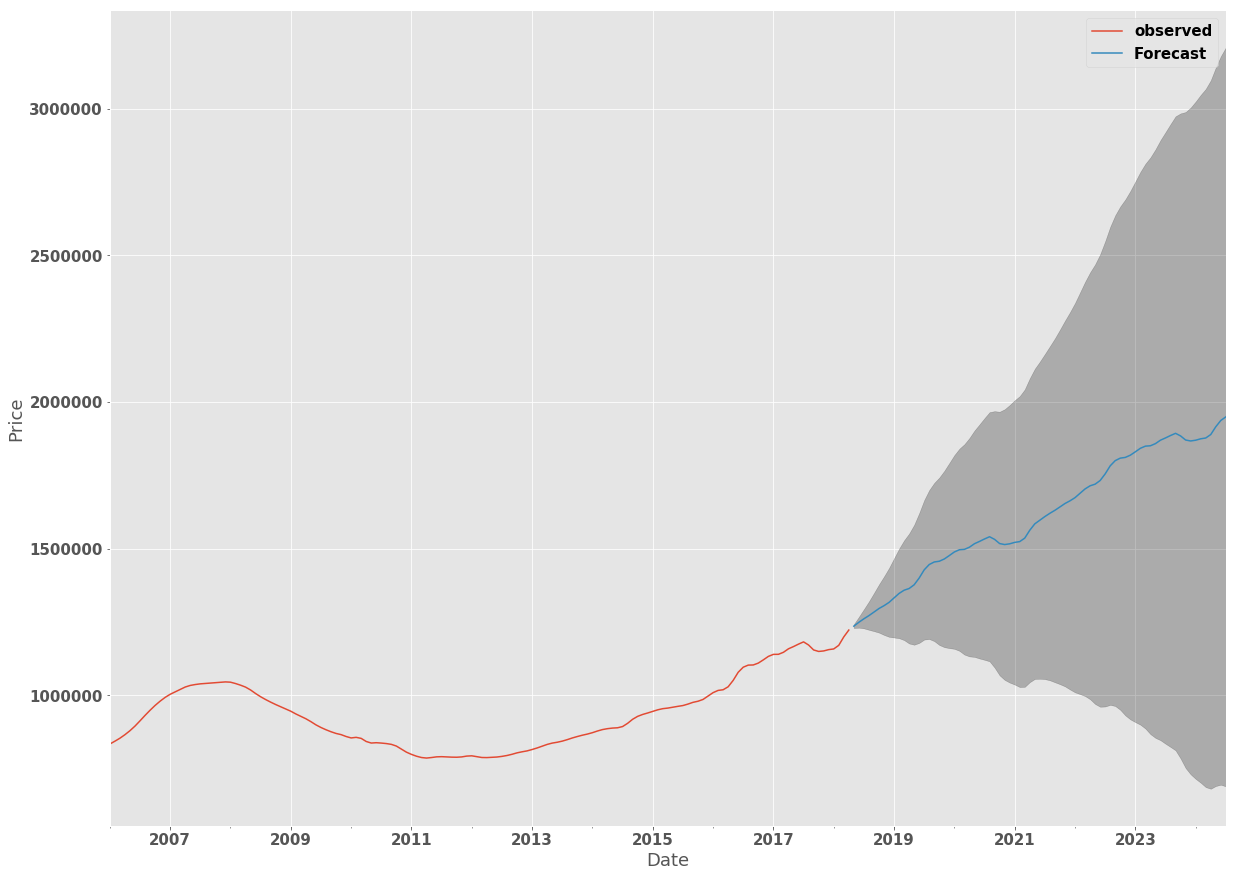

In [96]:
ax = utah_df[int(84060)]['2006':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

**This model is now finished. I will save and intepret the values at the end of this notebook**

I will now write more models to use all selected 9 zipcodes from above. The notebook would be too long I if kept all models in here. Therefore, I will use the 3rd model for other zipcodes and overwrite the values. I will save all results and ovservations for comparison and for selection into the portfolio. To see the results, look at the last section of the notebook.

## Modelling zipcode 84101 (Model #2)

Here I will repeat the process from model #1. However, I will adapt data to create the most reliable models.

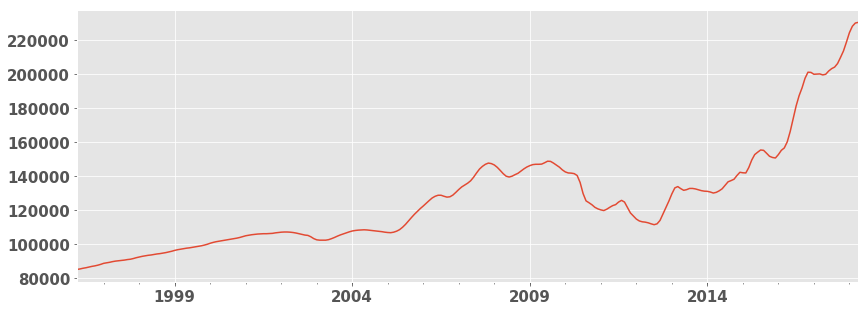

In [78]:
utah_df[int(84101)].plot()

In [84]:
diff_84101 = difference(utah_df[int(84101)])
difff_84101 = minus_rollmean(diff_84101,4)

In [85]:
DF_test(difff_84101)
#trend removed

(-7.7390646462716655, 1.0740152578854897e-11, 13, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3683.8515272396944)
Results of Dickey-Fuller Test:
Test Statistic                -7.739065e+00
p-value                        1.074015e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


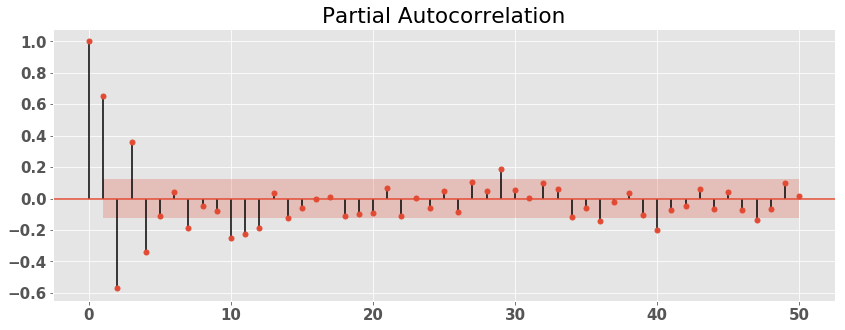

In [130]:
pacf(difff_84101,50)
#season - 3 or 29(?)

In [109]:
pdq =s_params(29)[0]
pdqs =s_params(29)[1]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(utah_df[int(84101)],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}season : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [110]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 29)
aic           3309.22
Name: 63, dtype: object

In [118]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(utah_df[int(84101)],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 29),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8023      0.031     26.078      0.000       0.742       0.863
ma.L1          0.7520      0.034     21.929      0.000       0.685       0.819
ar.S.L29       0.0930      0.052      1.804      0.071      -0.008       0.194
ma.S.L29      -0.6448      0.058    -11.027      0.000      -0.759      -0.530
sigma2      5.481e+05   3.84e+04     14.270      0.000    4.73e+05    6.23e+05


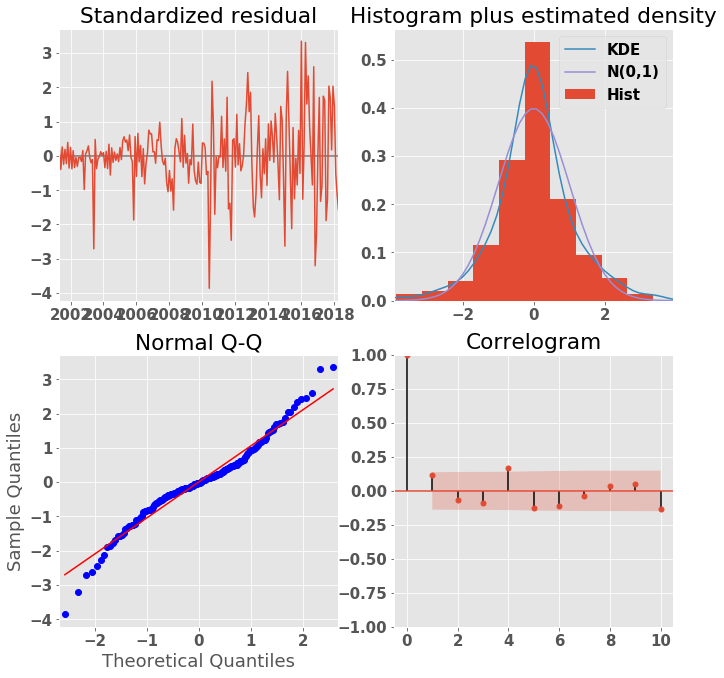

In [112]:
diagnostics(output)

In [113]:
# Get predictions starting from given date and calculate confidence intervals.
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

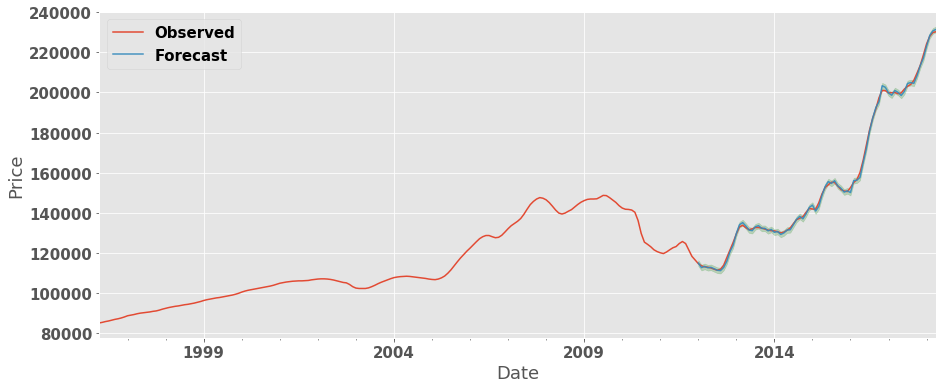

RMSE: 1039.7310110029068
mean: 156230.26315789475


In [114]:
get_predictions(utah_df[int(84101)],output,'2012-01-01')

In [134]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

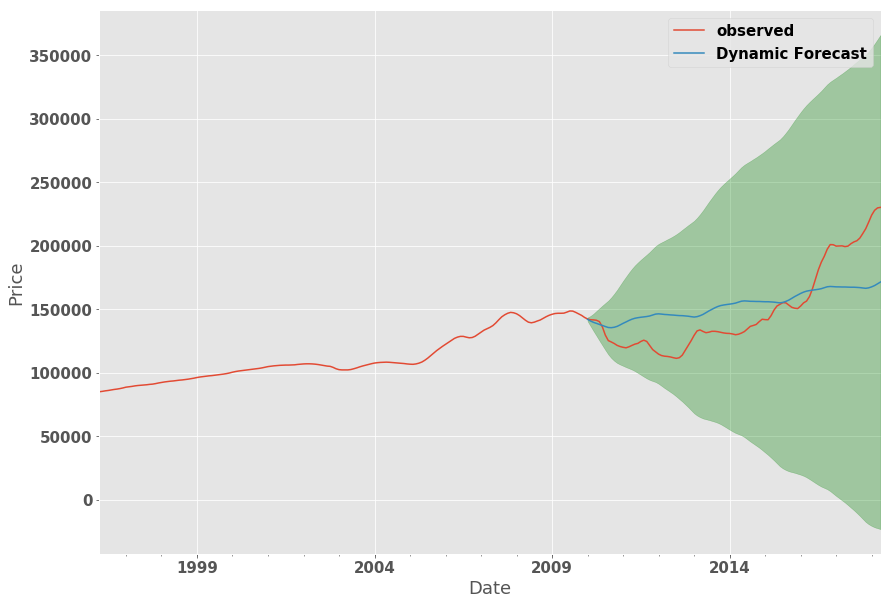

In [143]:
ax = utah_df[int(84101)].plot(label='observed', figsize=(14, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [145]:
# Extract the predicted and true values of our time series
values_forecasted = pred_dynamic.predicted_mean
values_truth = utah_df[int(84101)]['2010':]

rmse = np.sqrt(mean_squared_error(values_truth, values_forecasted))
print('RMSE: '+str(rmse))
print('mean: '+str(values_truth.mean()))

RMSE: 25226.192942764657
mean: 149212.0


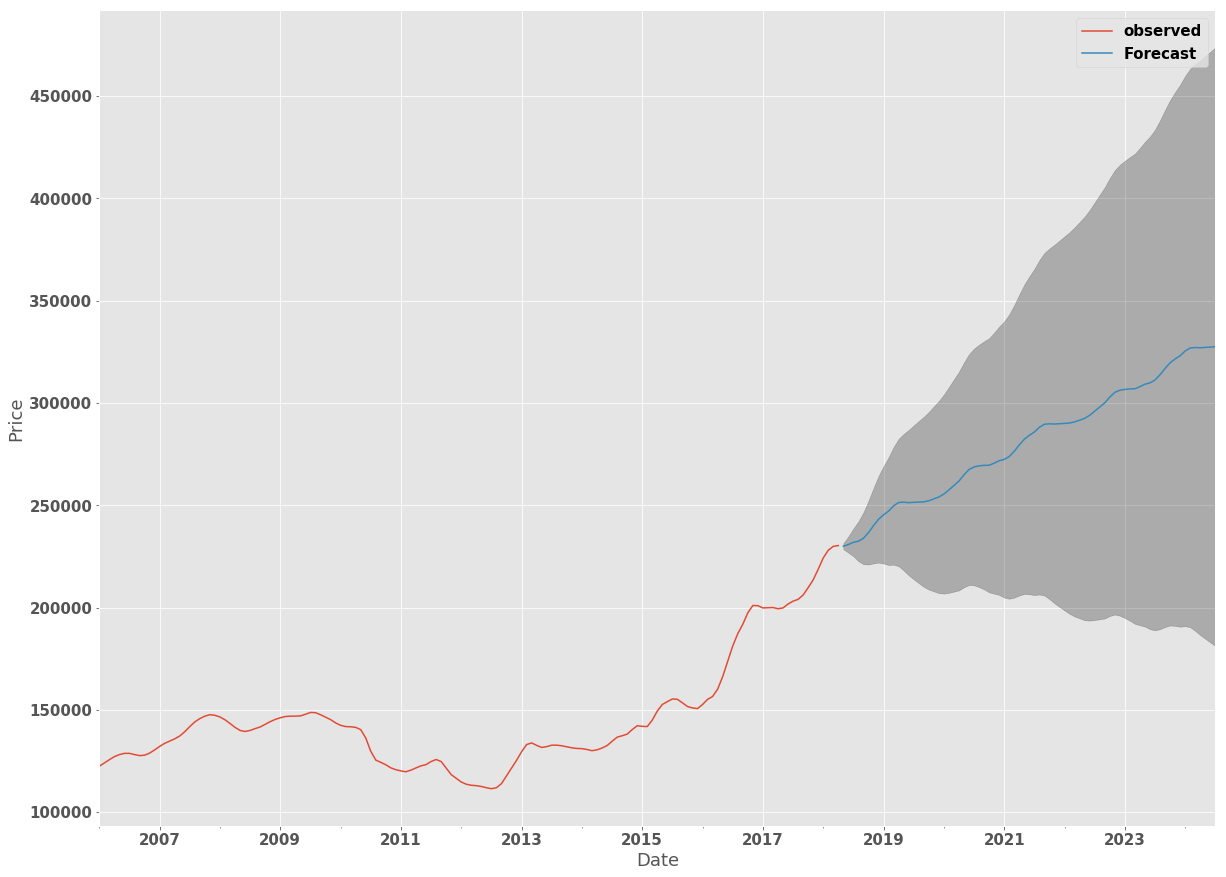

In [128]:
# Get forecast for a number of steps ahead in future
prediction = output.get_forecast(steps=75)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ax = utah_df[int(84101)]['2006':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

## Modelling zipcode 84081 (Model #3)

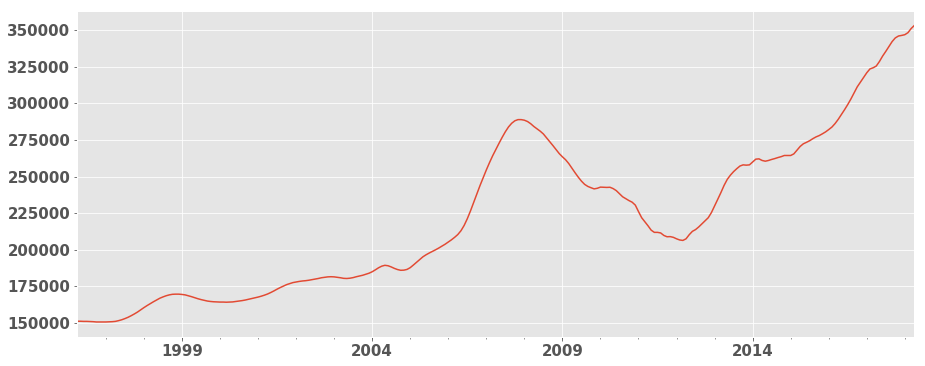

In [352]:
utah_df[int(84081)].plot();

In [359]:
diff_84081 = difference(utah_df[int(84081)])
difff_84081 = minus_rollmean(diff_84081,4)

DF_test(diff_84081)

(-2.787952297155488, 0.06001541114725739, 15, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 3707.7581872151563)
Results of Dickey-Fuller Test:
Test Statistic                  -2.787952
p-value                          0.060015
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


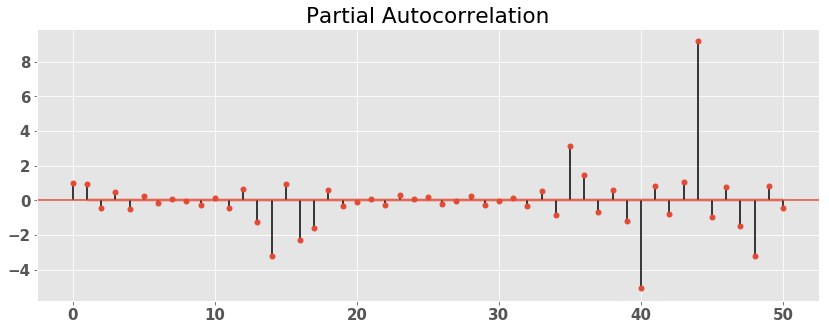

In [360]:
pacf(diff_84081,50)
#44

In [361]:
pdq =s_params(44)[0]
pdqs =s_params(44)[1]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(utah_df[int(84081)],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}season : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [362]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 44)
aic           2761.32
Name: 59, dtype: object

In [363]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(utah_df[int(84081)],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 44),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9365      0.023     40.381      0.000       0.891       0.982
ma.L1          0.6039      0.050     11.960      0.000       0.505       0.703
ma.S.L44      -2.9879      0.323     -9.245      0.000      -3.621      -2.354
sigma2      4.086e+04   7263.551      5.625      0.000    2.66e+04    5.51e+04


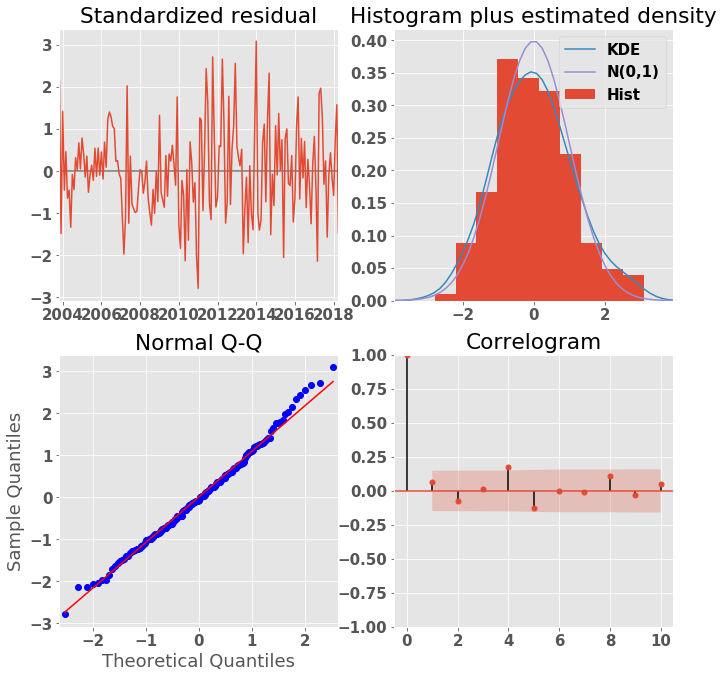

In [364]:
diagnostics(output)

In [365]:
# Get predictions starting from given date and calculate confidence intervals.
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

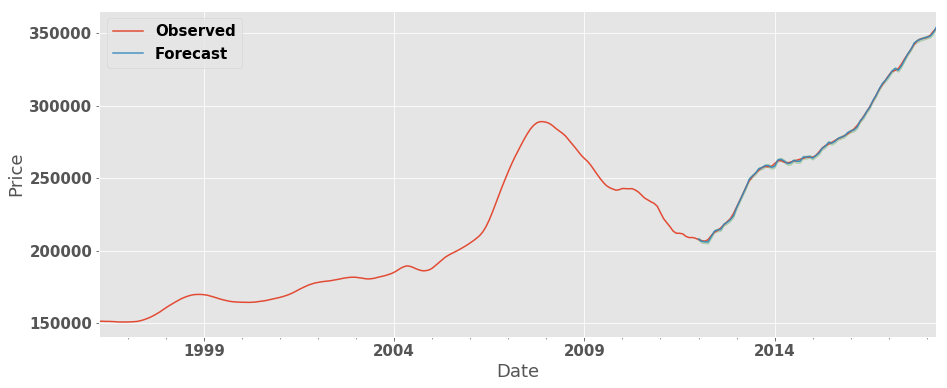

RMSE: 708.5745470165991
mean: 275885.5263157895


In [366]:
get_predictions(utah_df[int(84081)],output,'2012-01-01')

In [367]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

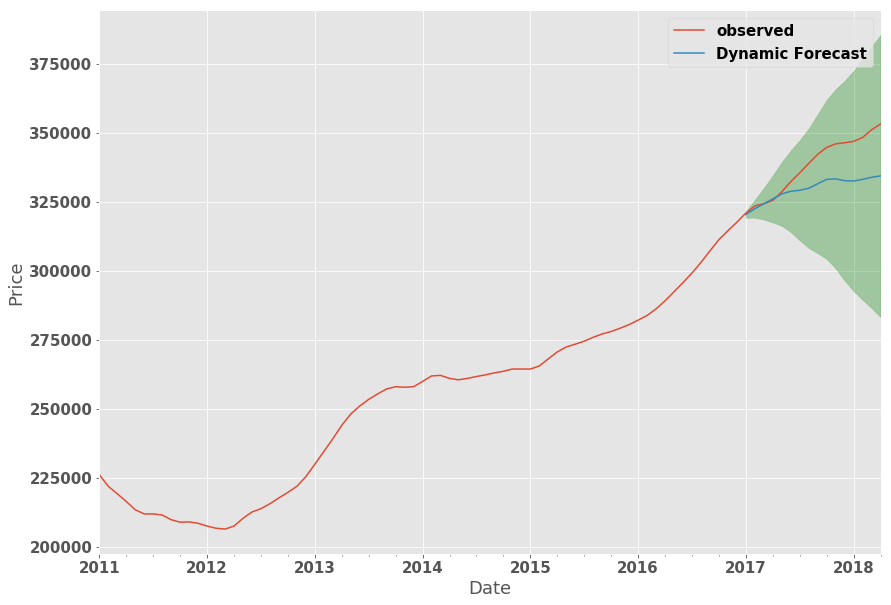

In [368]:
ax = utah_df[int(84081)]['2011':].plot(label='observed', figsize=(14, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [369]:
# Extract the predicted and true values of our time series
values_forecasted = pred_dynamic.predicted_mean
values_truth = utah_df[int(84081)]['2017':]

rmse = np.sqrt(mean_squared_error(values_truth, values_forecasted))
print('RMSE: '+str(rmse))
print('mean: '+str(values_truth.mean()))

RMSE: 10662.57377212032
mean: 338018.75


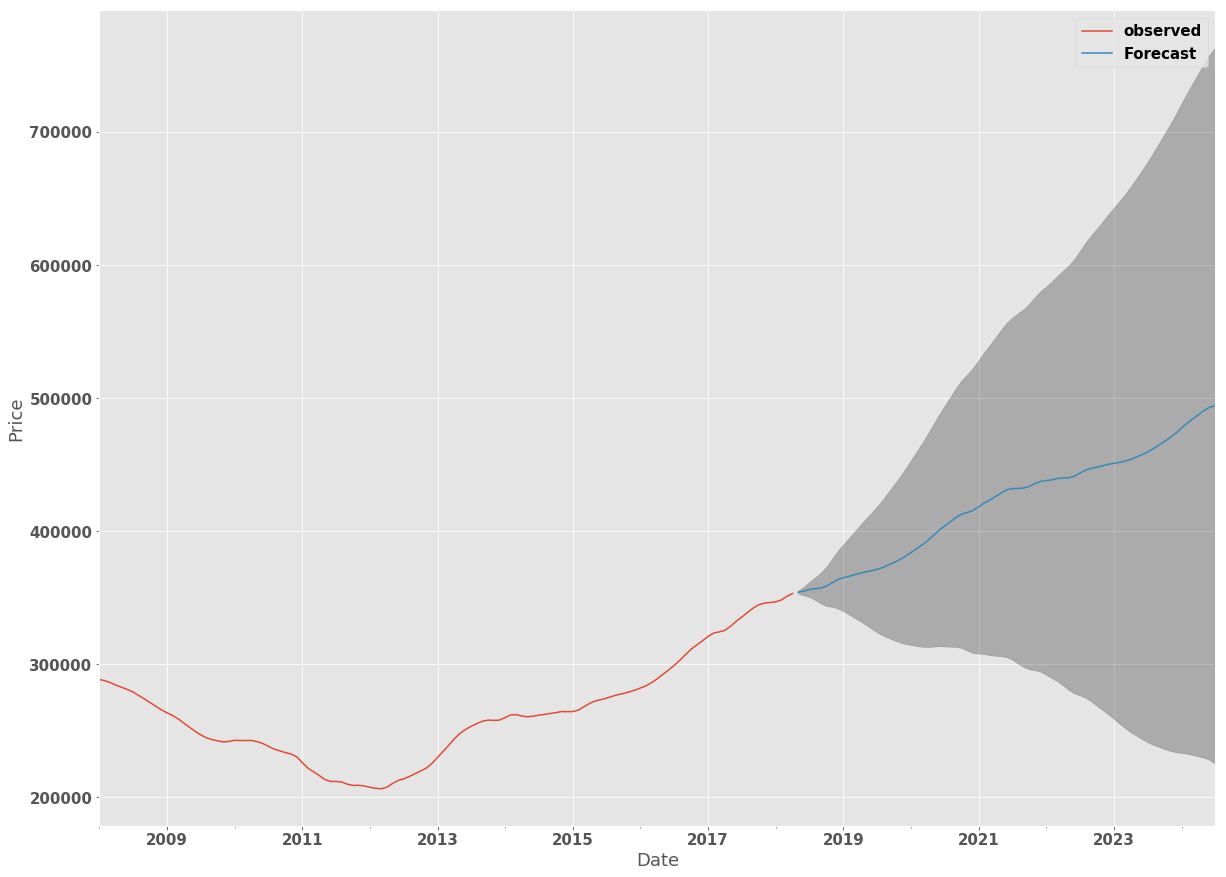

In [370]:
# Get forecast for a number of steps ahead in future
prediction = output.get_forecast(steps=75)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ax = utah_df[int(84081)]['2008':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Step 5: Interpreting Results

### Zipcode: 84060, Park City in Summit
* 4/2018 -  1 222 100
* 2024 - 1 900 000
* ROI: 55%

### Zipcode: 84101, Salt Lake City in Salt Lake
* 4/2018 -  230 000
* 2024 - 325 000
* ROI: 41%

### Zipcode: 84111, Salt Lake City in Salt Lake
* 4/2018 - 309 000
* 2024 - 500 000
* ROI: 60%

### Zipcode: 84757, New Harmony in Washington
* 4/2018 - 416 600
* 2024 - 800 000
* ROI: 92%
* model should be re-evaluated

### Zipcode: 84096, Herriman in Salt Lake
* 4/2018 - 420 800
* 2024 - 550 000
* ROI: 31%


### Zipcode: 84115, South Salt Lake in Salt Lake
* 4/2018 - 280 000
* 2024 - 400 000
* ROI: 42%


### Zipcode: 84106, Salt Lake City in Salt Lake
* 4/2018 - 378 000
* 2024 - 550 000
* ROI: 45%

### Zipcode: 84044, Magna in Salt Lake
* 4/2018 - 249 800
* 2024 - 480 000
* ROI: 44%

### Zipcode: 84081, West Jordan in Salt Lake
* 4/2018 - 353 200
* 2024 - 480 000
* ROI: 36%

# Final selection
To create the most diversified portofio of zipcodes with historically excellent performance as well as high prediction for the next five years, I have selected the following 5 zipcodes:

* 84111, Salt Lake City
* 84060, Summit
* 84106, Salt Lake City
* 84044, Magna
* 84115, South Salt Lake



# Recommendations

The real-estate firm is advised to invest in the above 5 zipcodes because:
* The historical perfomance in outperforming other areas on average since 1994
* Except for two zipcodes in Salt Lake City, other three are in other areas. This makes the porfolio diversified and not dependent on a single location.
* The selected zipcodes have varied average value of properties (between 1 mil and 280k in 2018). This is another diversification, as they are appropriate for different customer segments and various purchasing powers.
* The expected ROI in 2024 is between 60% and 42%

In [ ]:
#attempting subplots

#to_plot = [weber, davis]
#to_plot_names = ['weber', 'davis']

#fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,4),sharex=True)
#fig.subplots_adjust(top=0.92, bottom=0.08, left=0.01, right=0.9, hspace=0.25,wspace=0.2)
#fig.suptitle('Average house price in Utah counties')

#for ax, feature, name in zip(axes.flatten(), to_plot, to_plot_names):

 #   ax.plot(feature)
  #  ax.xaxis.set_major_formatter(plt.NullFormatter())
   # plt.legend(feature)

    